## Load the dataset and check for missing rows

In [36]:
import pandas as pd

# Load data into a DataFrame
df = pd.read_csv(r'C:\Users\teore\Downloads\BACHELOR PROJECT\cleaned_final_database.csv')


# Check for rows with missing values
# If all rows are filled, this should be zero
missing_rows = df.isnull().sum(axis=1).sum()
if missing_rows > 0:
    print(f"There are {missing_rows} missing values. Please fill or clean these rows.")
else:
    print("All rows are filled!")

# Strip whitespace from each cell
df = df.astype(str).apply(lambda x: x.str.strip())

# Save the updated DataFrame back to 'cleaned_database.csv'
df.to_csv(r'C:\Users\teore\Downloads\BACHELOR PROJECT\cleaned_final_database.csv', index=False)

print("RecipeID column adjusted successfully. The changes are saved in 'cleaned_final_database.csv'.")

All rows are filled!
RecipeID column adjusted successfully. The changes are saved in 'cleaned_final_database.csv'.


## Apply different normalization methods

In [37]:
import pandas as pd
import unicodedata
import re
from nltk.stem import WordNetLemmatizer


# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\cleaned_final_database.csv")

lemmatizer = WordNetLemmatizer()

# Function to remove accents
def remove_accents(text):
    normalized_text = unicodedata.normalize('NFKD', text)
    return ''.join(c for c in normalized_text if not unicodedata.combining(c))

# Function to lemmatize words
def lemmatize_words(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Function to remove brackets and text inside
def remove_brackets(text):
    return re.sub(r"\[.*?\]|\(.*?\)", "", text)
    

df['ingredient_gt'] = df['ingredient_gt'].str.lower().apply(remove_brackets).apply(remove_accents)
df['ingredient_and_quantity'] = df['ingredient_and_quantity'].str.lower().apply(remove_brackets).apply(remove_accents)

recipe_id = df['recipeID']
quantity_phrase = df['ingredient_and_quantity'].fillna("").astype(str)
ingredient_gt = df['ingredient_gt'].fillna("").astype(str)

print(df)

df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\unlemmatized_final_database.csv")

       recipeID    ingredient_and_quantity               ingredient_gt
0             1          4 tbsps gochujang              gochujang base
1             1            6 tbsps ketchup                     ketchup
2             1        6 tbsps maple syrup                 maple syrup
3             1          4 tbsps soy sauce                   soy sauce
4             1  2 tbsps rice wine vinegar  seasoned rice wine vinegar
...         ...                        ...                         ...
11571       891      8 slices of parma ham                   parma ham
11572       891       4 frozen cod fillets                         cod
11573       891                       salt                        salt
11574       891                     pepper                      pepper
11575       891                  olive oil                   olive oil

[11576 rows x 3 columns]


## FLAN T-5 First Prompt (After normalization)

In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the model and tokenizer
model_name = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)


def llm_ingredient_extraction(text):
    prompt = f"I will give you a sentence with a quantity and an ingredient. I need to extract the ingredient from this sentence. Make sure that the ingredient extracted doesn’t contain any more information. From this sentence {text}, the ingredient is:"
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**inputs)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)
 
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\unlemmatized_final_database.csv")

df['ingredient_extracted'] = df['ingredient_and_quantity'].apply(llm_ingredient_extraction)

# Apply post-lemmatization in 'ingredient_extracted' and 'ingredient_gt'
df['ingredient_extracted'].apply(lemmatize_words)
df['ingredient_gt'].apply(lemmatize_words)

print(df[['recipeID', 'ingredient_and_quantity', 'ingredient_gt', 'ingredient_extracted']])

df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\post_lemmatized_extracted_ingredients_copy1.csv")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
C:\Users\teore\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\teore\Lib\site-packages\transformers\generation\utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the gen

       recipeID    ingredient_and_quantity               ingredient_gt  \
0             1          4 tbsps gochujang              gochujang base   
1             1            6 tbsps ketchup                     ketchup   
2             1        6 tbsps maple syrup                 maple syrup   
3             1          4 tbsps soy sauce                   soy sauce   
4             1  2 tbsps rice wine vinegar  seasoned rice wine vinegar   
...         ...                        ...                         ...   
11571       891      8 slices of parma ham                   parma ham   
11572       891       4 frozen cod fillets                         cod   
11573       891                       salt                        salt   
11574       891                     pepper                      pepper   
11575       891                  olive oil                   olive oil   

      ingredient_extracted  
0                gochujang  
1                  ketchup  
2              maple syr

In [65]:
import pandas as pd
from Levenshtein import distance

def normalized_levenshtein_similarity(s1, s2):
    """Calculate normalized Levenshtein similarity between two strings."""
    max_len = max(len(s1), len(s2))
    if max_len == 0:  # Avoid division by zero
        return 1.0
    return 1 - distance(s1, s2) / max_len

def jaccard_similarity(s1, s2):
    """Calculate Jaccard similarity between two strings using tokenization."""
    set1 = set(s1.split())
    set2 = set(s2.split())
    intersection = len(set1 & set2)  # Common tokens
    union = len(set1 | set2)        # All unique tokens
    if union == 0:  # Avoid division by zero
        return 0.0
    return intersection / union

def flexible_similarity(ground_truth, extracted, jaccard_threshold=0.2, levenshtein_threshold=0.7):
    """
    Use Jaccard similarity for phrases and Levenshtein similarity for single words.
    
    Args:
        ground_truth (str): Ground truth ingredient.
        extracted (str): Extracted ingredient.
        jaccard_threshold (float): Threshold for Jaccard similarity.
        levenshtein_threshold (float): Threshold for Levenshtein similarity.
    
    Returns:
        str: 'Match' if similarity meets the appropriate threshold, else 'Mismatch'.
    """
    levenshtein_sim = normalized_levenshtein_similarity(ground_truth, extracted)
    
    if levenshtein_sim >= levenshtein_threshold:
        return 'Match'
    
    jaccard_sim = jaccard_similarity(ground_truth, extracted)
    
    if jaccard_sim >= jaccard_threshold:
        return 'Match'
    
    return 'Mismatch'

def double_check_mismatches(mismatches):
    double_checked_mismatches = []
    true_matches = []  # Variable to store true matches that were initially mismatches
    for recipeid, gt, extracted in mismatches:
        result = flexible_similarity(gt, extracted, jaccard_threshold=0.5, levenshtein_threshold=0.7)
        if result == 'Match':
            true_matches.append((recipeid, gt, extracted))  # Store true match in the true_matches list
        double_checked_mismatches.append((recipeid, gt, extracted, result))
    return double_checked_mismatches, true_matches

def match_percentage(matches, mismatches):
    total = len(matches) + len(mismatches)
    if total == 0:
        return 0
    return len(matches) / total * 100


def second_match_percentage(matches, mismatches, true_matches):
    """ Function to calculate the final percentage after double checking
    """
    length_mismatches = len(mismatches) - len(true_matches)
    length_matches = len(matches) + len(true_matches)
    total = length_mismatches + length_matches
    if total == 0:
        return 0
    return length_matches / total * 100

In [66]:
import pandas as pd
import os

# # Rename files for easier understanding (DO IT ONCE!)
# old_file_path = r"C:\Users\teore\Downloads\BACHELOR PROJECT\post_lemmatized_extracted_ingredients_copy1.csv"
# new_file_path = r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\post_lemmatized_extracted_ingredients_pca.csv"
# os.rename(old_file_path, new_file_path)

df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\post_lemmatized_extracted_ingredients_pca.csv")

# Remove accents and lemmatize each row from the 'ingredient_extracted' column
df['ingredient_gt'] = df['ingredient_gt'].apply(lemmatize_words)
df['ingredient_extracted'] = df['ingredient_extracted'].apply(lemmatize_words)

# Convert the Dataframe into a variable for easier handling
recipe_id = df['recipeID']
ingredient_gt = df['ingredient_gt']
ingredient_extracted = df['ingredient_extracted'].str.lower()

#Strict Matching
def match_checker_method_1(recipe_id, ingredient_gt, ingredient_extracted):
    match = []
    not_match = []
    for recipeid, gt, extracted in zip(recipe_id, ingredient_gt, ingredient_extracted):
        if (extracted == gt):
            match.append((recipeid, gt, extracted))
        else:
            not_match.append((recipeid, gt, extracted))
    return recipeid, match, not_match

# Set variables for each result
recipe_id_1, matches_1, mismatches_1 = match_checker_method_1(recipe_id, ingredient_gt, ingredient_extracted)

print("Matches:", len(matches_1))
print("Mismatches:", len(mismatches_1))
print("Match Percentage:", match_percentage(matches_1, mismatches_1))

import random
sample = random.sample(mismatches_1, 100)

print(sample)

Matches: 8943
Mismatches: 2633
Match Percentage: 77.25466482377333
[(27, 'potato', 'new potato'), (351, 'sichuan pepper', 'sichuan peppercorn'), (878, 'ginger', 'ground ginger'), (217, 'mayonnaise', 'mayo'), (383, 'cumin', 'ground cumin'), (316, 'chilli', 'bird eye chilli'), (363, 'lemon', 'lemon juice'), (88, 'puy lentil', 'pylenol'), (536, '‘nduja paste', 'nija'), (307, 'star anise', 'anise'), (561, 'lemon', 'lemon, zest'), (500, 'tomato puree', 'tomato passata'), (88, 'pepper', 'red pepper'), (369, 'mayonnaise', 'vegan mayonnaise'), (357, 'garlic', 'clove of garlic'), (689, 'cumin', 'ground cumin'), (40, 'yoghurt', 'greek yoghurt'), (427, 'self-raising flour', 'flour'), (34, 'wine vinegar', 'white wine vinegar'), (252, 'coriander', 'coriander leaf'), (331, 'pumpkin', 'pumpkin flesh'), (190, 'cumin', 'ground cumin'), (481, 'celery', 'celery stalk'), (563, 'basmati rice', 'basmati tilda rice'), (104, 'sage leaf', 'sage'), (248, 'cabbage', 'white cabbage'), (365, 'cardamom pod', 'carda

In [67]:
# Level 1
def match_checker_method_2(recipe_id, ingredient_gt, ingredient_extracted):
    match = []
    not_match = []
    for recipeid, gt, extracted in zip(recipe_id, ingredient_gt, ingredient_extracted):
        if (extracted in gt):
            match.append((recipeid, gt, extracted))
        else:
            not_match.append((recipeid, gt, extracted))
    return recipeid, match, not_match

recipe_id_2, matches_2, mismatches_2 = match_checker_method_2(recipe_id, ingredient_gt, ingredient_extracted)

print("Matches:", len(matches_2))
print("Mismatches:", len(mismatches_2))
print("Match Percentage:", match_percentage(matches_2, mismatches_2))

Matches: 9370
Mismatches: 2206
Match Percentage: 80.94333102971666


In [68]:
# Level 2
def match_checker_method_3(recipe_id, ingredient_gt, ingredient_extracted):
    match = []
    not_match = []
    for recipeid, gt, extracted in zip(recipe_id, ingredient_gt, ingredient_extracted):
        if (gt in extracted):
            match.append((recipeid, gt, extracted))
        else:
            not_match.append((recipeid, gt, extracted))
    return recipeid, match, not_match

#FLAN T-5 results
recipe_id_3, matches_3, mismatches_3 = match_checker_method_3(recipe_id, ingredient_gt, ingredient_extracted)

print("Matches:", len(matches_3))
print("Mismatches:", len(mismatches_3))
print("Match Percentage:", match_percentage(matches_3, mismatches_3))

Matches: 10879
Mismatches: 697
Match Percentage: 93.97892190739461


In [69]:
# Level 3
def match_checker_method_4(recipe_id, ingredient_gt, ingredient_extracted):
    match = []
    not_match = []
    for recipeid, gt, extracted in zip(recipe_id, ingredient_gt, ingredient_extracted):
        if (gt in extracted) or (extracted in gt):
            match.append((recipeid, gt, extracted))
        else:
            not_match.append((recipeid, gt, extracted))
    return recipeid, match, not_match

recipe_id_4, matches_4, mismatches_4 = match_checker_method_4(recipe_id, ingredient_gt, ingredient_extracted)

# Double check mismatches using flexible_similarity
double_checked_mismatches, true_matches = double_check_mismatches(mismatches_4)


print("Matches:", len(matches_4))
print("Mismatches:", len(mismatches_4))
print("Match Percentage:", match_percentage(matches_4, mismatches_4))
# print(mismatches_4)

Matches: 11306
Mismatches: 270
Match Percentage: 97.66758811333794


In [70]:
# Checked Loose
final_results_4 = second_match_percentage(matches_4, mismatches_4, true_matches)
print("Second Phase Matches:", final_results_4)

# New variables for updated listof matches and mismatches
new_mismatches_4 = []
for mismatch in mismatches_4:
    if mismatch not in true_matches:
        new_mismatches_4.append(mismatch)
# New variable for updated matches
new_matches_4 = matches_4 + true_matches 


import random
sample = random.sample(new_mismatches_4, 100)

print(sample)

Second Phase Matches: 98.3154803040774
[(423, 'cereal', 'safflower'), (276, 'vegetable stock', 'veg stock'), (671, 'zucchini', 'courgette'), (218, 'emmenthal', 'emmental cheese'), (271, 'sun-dried tomato', 'olive oil'), (547, 'macaroni or spaghetti', 'pasta'), (509, 'taco shell or corn tortilla', 'corn/wheat tortilla'), (225, 'zucchini', 'courgette'), (169, 'lentil and kidney bean', 'red kidney bean'), (283, 'cheese slice', 'american cheese'), (635, 'minced meat', 'plant-based mince'), (16, 'carbonated water', 'sparkling water'), (345, 'chipotle chile', 'chipotle chilli flake'), (231, 'soft corn tortilla', 'taco tortilla'), (16, '‘nduja', 'nija'), (179, 'chipotle chile or chilli', 'chipotle chilli flake'), (540, 'cheese slice', 'cheddar cheese'), (875, 'zucchini', 'courgette'), (543, 'something creamy', 'cream cheese'), (245, 'sesame seed hamburger bun', 'seeded bun'), (704, 'minced meat', 'plant based mince'), (379, 'pita bread', 'sour cream'), (494, 'tilda coconut, chilli and lemongr

## Statistical Functions

Method 1:      recipeID  MatchPercentage
0           1        65.217391
1           2        71.428571
2           3        50.000000
3           4        75.000000
4           5        66.666667
..        ...              ...
886       887        88.888889
887       888       100.000000
888       889        81.818182
889       890        62.500000
890       891        90.000000

[891 rows x 2 columns]
Method 2:      recipeID  MatchPercentage
0           1        78.260870
1           2        71.428571
2           3        50.000000
3           4        87.500000
4           5        75.000000
..        ...              ...
886       887        88.888889
887       888       100.000000
888       889        90.909091
889       890        62.500000
890       891        90.000000

[891 rows x 2 columns]
Method 3:      recipeID  MatchPercentage
0           1        82.608696
1           2       100.000000
2           3        83.333333
3           4        87.500000
4           5        83

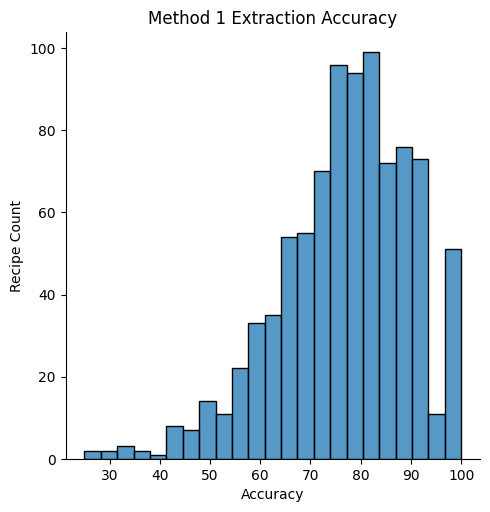

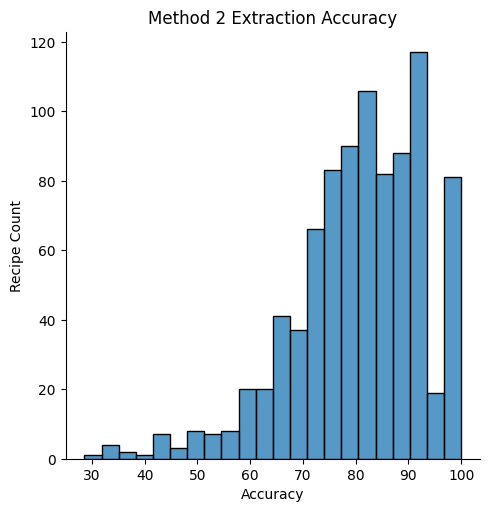

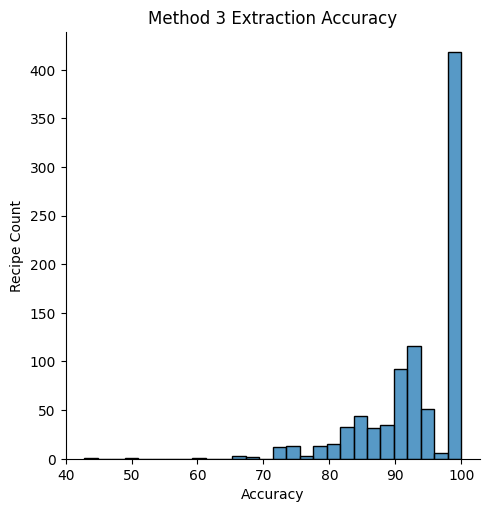

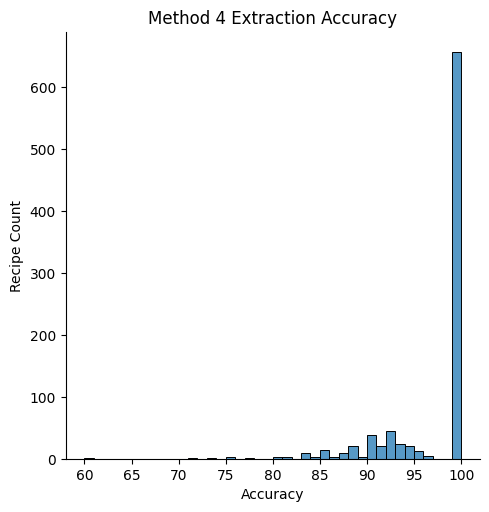

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dictionaries to store match percentages per recipeID
match_percentage_per_recipe_m_1 = {}
match_percentage_per_recipe_m_2 = {}
match_percentage_per_recipe_m_3 = {}
match_percentage_per_recipe_m_4 = {}

# Group by `recipeID` and apply matching functions
for recipe_id, row in df.groupby('recipeID'):
    ingredients_gt_per_id = row['ingredient_gt'].tolist()
    ingredients_extracted_per_id = row['ingredient_extracted'].tolist()

    # Apply match checking functions
    _, matches_per_id_1, mismatches_per_id_1 = match_checker_method_1(
        [recipe_id] * len(ingredients_gt_per_id), ingredients_gt_per_id, ingredients_extracted_per_id
    )
    _, matches_per_id_2, mismatches_per_id_2 = match_checker_method_2(
        [recipe_id] * len(ingredients_gt_per_id), ingredients_gt_per_id, ingredients_extracted_per_id
    )
    _, matches_per_id_3, mismatches_per_id_3 = match_checker_method_3(
        [recipe_id] * len(ingredients_gt_per_id), ingredients_gt_per_id, ingredients_extracted_per_id
    )
    _, matches_per_id_4, mismatches_per_id_4 = match_checker_method_4(
        [recipe_id] * len(ingredients_gt_per_id), ingredients_gt_per_id, ingredients_extracted_per_id
    )
    
    # Use match_percentage function to calculate and store match percentages
    match_percentage_per_recipe_m_1[recipe_id] = match_percentage(matches_per_id_1, mismatches_per_id_1) 
    match_percentage_per_recipe_m_2[recipe_id] = match_percentage(matches_per_id_2, mismatches_per_id_2) 
    match_percentage_per_recipe_m_3[recipe_id] = match_percentage(matches_per_id_3, mismatches_per_id_3) 
    match_percentage_per_recipe_m_4[recipe_id] = match_percentage(matches_per_id_4, mismatches_per_id_4) 

    
# Convert the results into DataFrames for easier handling
recipe_percentage_1 = pd.DataFrame(list(match_percentage_per_recipe_m_1.items()), columns=['recipeID', 'MatchPercentage'])
recipe_percentage_2 = pd.DataFrame(list(match_percentage_per_recipe_m_2.items()), columns=['recipeID', 'MatchPercentage'])
recipe_percentage_3 = pd.DataFrame(list(match_percentage_per_recipe_m_3.items()), columns=['recipeID', 'MatchPercentage'])
recipe_percentage_4 = pd.DataFrame(list(match_percentage_per_recipe_m_4.items()), columns=['recipeID', 'MatchPercentage'])

# Display results
print('Method 1:', recipe_percentage_1)
print('Method 2:', recipe_percentage_2)
print('Method 3:', recipe_percentage_3)
print('Method 4:', recipe_percentage_4)

# Calculate and display the average match percentage for each method
average_m_1 = recipe_percentage_1['MatchPercentage'].mean()
average_m_2 = recipe_percentage_2['MatchPercentage'].mean()
average_m_3 = recipe_percentage_3['MatchPercentage'].mean()
average_m_4 = recipe_percentage_4['MatchPercentage'].mean()

print(f'Average Match Percentage for Method 1: {average_m_1:.3f}%')
print(f'Average Match Percentage for Method 2: {average_m_2:.3f}%')
print(f'Average Match Percentage for Method 3: {average_m_3:.3f}%')
print(f'Average Match Percentage for Method 4: {average_m_4:.3f}%')

# Standard Deviation
print('Standard Deviation for Method 1:', recipe_percentage_1['MatchPercentage'].std())
print('Standard Deviation for Method 2:', recipe_percentage_2['MatchPercentage'].std())
print('Standard Deviation for Method 3:', recipe_percentage_3['MatchPercentage'].std())
print('Standard Deviation for Method 4:', recipe_percentage_4['MatchPercentage'].std())

# Max and Min
print('\nMax Percentage for Method 1:', recipe_percentage_1['MatchPercentage'].max())
print('Min Percentage for Method 1:', recipe_percentage_1['MatchPercentage'].min())
print('Max Percentage for Method 2:', recipe_percentage_2['MatchPercentage'].max())
print('Min Percentage for Method 2:', recipe_percentage_2['MatchPercentage'].min())
print('Max Percentage for Method 3:', recipe_percentage_3['MatchPercentage'].max())
print('Min Percentage for Method 3:', recipe_percentage_3['MatchPercentage'].min())
print('Max Percentage for Method 4:', recipe_percentage_4['MatchPercentage'].max())
print('Min Percentage for Method 4:', recipe_percentage_4['MatchPercentage'].min())




# Plot Histograms
for i, df in enumerate([recipe_percentage_1, recipe_percentage_2, recipe_percentage_3, recipe_percentage_4], start=1):
    sns.displot(data=df, x="MatchPercentage")
    plt.xlabel("Accuracy")
    plt.ylabel("Recipe Count")
    plt.title(f'Method {i} Extraction Accuracy')
    
    # plt.savefig(f"Method_{i}_extraction_accuracy.png", bbox_inches='tight')
    
    plt.show()


## Statistical Functions (Checked Loose)

Updated Match Percentages by Recipe:      recipeID  MatchPercentage
0           1       100.000000
1           2       100.000000
2           3        83.333333
3           4       100.000000
4           5        91.666667
..        ...              ...
886       887       100.000000
887       888       100.000000
888       889       100.000000
889       890        87.500000
890       891       100.000000

[891 rows x 2 columns]

Average Match Percentage: 98.22%
Standard Deviation: 4.20
Max Match Percentage: 100.00%
Min Match Percentage: 60.00%


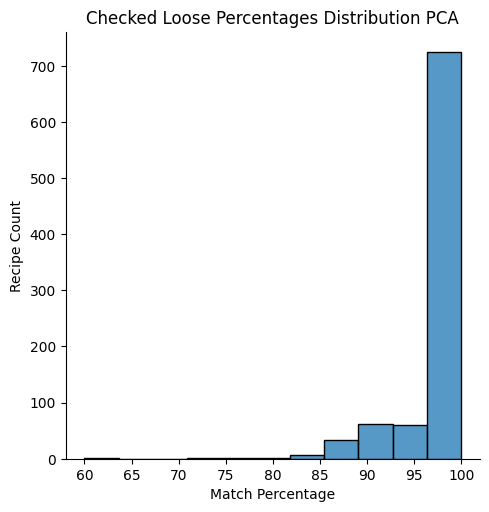

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrames for new matches and mismatches
new_matches_df = pd.DataFrame(
    new_matches_4, columns=['recipeID', 'ingredient_gt', 'ingredient_extracted']
).assign(status='Match')  # Label as matches

new_mismatches_df = pd.DataFrame(
    new_mismatches_4, columns=['recipeID', 'ingredient_gt', 'ingredient_extracted']
).assign(status='Mismatch')  # Label as mismatches

# Combine the new matches and mismatches into one DataFrame
updated_df = pd.concat([new_matches_df, new_mismatches_df], ignore_index=True)

# Initialize a dictionary to store match percentages
updated_match_percentage = {}

# Group by `recipeID` and calculate match percentages
for recipe_id, group in updated_df.groupby('recipeID'):
    matches_per_id = group[group['status'] == 'Match']
    mismatches_per_id = group[group['status'] == 'Mismatch']
    
    # Calculate match percentage
    total_count = len(matches_per_id) + len(mismatches_per_id)
    if total_count > 0:
        updated_match_percentage[recipe_id] = (len(matches_per_id) / total_count) * 100
    else:
        updated_match_percentage[recipe_id] = 0  # No matches or mismatches

# Convert the match percentages into a DataFrame
updated_recipe_percentage = pd.DataFrame(
    list(updated_match_percentage.items()), columns=['recipeID', 'MatchPercentage']
)

# Insights
print('Updated Match Percentages by Recipe:', updated_recipe_percentage)

# Calculate and display overall statistics
average_match_percentage = updated_recipe_percentage['MatchPercentage'].mean()
std_match_percentage = updated_recipe_percentage['MatchPercentage'].std()
max_match_percentage = updated_recipe_percentage['MatchPercentage'].max()
min_match_percentage = updated_recipe_percentage['MatchPercentage'].min()

print(f'\nAverage Match Percentage: {average_match_percentage:.2f}%')
print(f'Standard Deviation: {std_match_percentage:.2f}')
print(f'Max Match Percentage: {max_match_percentage:.2f}%')
print(f'Min Match Percentage: {min_match_percentage:.2f}%')

# Plot a histogram for the updated match percentages
sns.displot(data=updated_recipe_percentage, x="MatchPercentage", kde=False)
plt.xlabel("Match Percentage")
plt.ylabel("Recipe Count")
plt.savefig(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\pca_distribution_checked_loose.png")
plt.title("Checked Loose Percentages Distribution PCA")
plt.show()


# Old Matches Bins

In [30]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Function to categorize match percentages into bins
# def categorize_into_bins(match_percentage):
#     if match_percentage == 100:
#         return "100%"
#     elif 95 <= match_percentage < 100:
#         return "95%-99%"
#     elif 90 <= match_percentage < 95:
#         return "90%-94%"
#     elif 85 <= match_percentage < 90:
#         return "85%-89%"
#     elif 80 <= match_percentage < 85:
#         return "80%-84%"
#     else:
#         return "Below 80%"

# # Apply categorization for each method
# bins_1 = [categorize_into_bins(m) for m in match_percentage_per_recipe_m_1.values()]
# bins_2 = [categorize_into_bins(m) for m in match_percentage_per_recipe_m_2.values()]
# bins_3 = [categorize_into_bins(m) for m in match_percentage_per_recipe_m_3.values()]
# bins_4 = [categorize_into_bins(m) for m in match_percentage_per_recipe_m_4.values()]

# # Create DataFrames to store frequency distribution
# frequency_df_1 = pd.DataFrame(bins_1, columns=['Match Percentage Range'])
# frequency_df_2 = pd.DataFrame(bins_2, columns=['Match Percentage Range'])
# frequency_df_3 = pd.DataFrame(bins_3, columns=['Match Percentage Range'])
# frequency_df_4 = pd.DataFrame(bins_4, columns=['Match Percentage Range'])

# # Get the frequency distribution for each method
# frequency_distribution_1 = frequency_df_1['Match Percentage Range'].value_counts().sort_index()
# frequency_distribution_2 = frequency_df_2['Match Percentage Range'].value_counts().sort_index()
# frequency_distribution_3 = frequency_df_3['Match Percentage Range'].value_counts().sort_index()
# frequency_distribution_4 = frequency_df_4['Match Percentage Range'].value_counts().sort_index()

# # Print frequency distributions
# print(f'Frequency Distribution for Method 1:\n{frequency_distribution_1}')
# print(f'Frequency Distribution for Method 2:\n{frequency_distribution_2}')
# print(f'Frequency Distribution for Method 3:\n{frequency_distribution_3}')
# print(f'Frequency Distribution for Method 4:\n{frequency_distribution_4}')

# # Optionally, plot the distributions
# for i, distribution in enumerate([frequency_distribution_1, frequency_distribution_2, frequency_distribution_3, frequency_distribution_4], start=1):
#     distribution.plot(kind='bar', title=f'Method {i} Frequency Distribution')
#     plt.xlabel("Match Percentage Range")
#     plt.ylabel("Number of Recipes")
#     plt.xticks(rotation=45)
#     plt.show()
#     plt.tight_layout()  # Adjust layout to prevent label overlap
#     #Save the figure before showing it
#     plt.savefig(f"Method_{i}_Frequency_Distribution_Dataset2.png", bbox_inches='tight')
    
#     # Optionally, show the plot
#     plt.show()
    
#     # Close the plot to avoid issues with subsequent figures
#     plt.close()


# Checked Loose (New Matches)

In [31]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Function to categorize match percentages into bins
# def categorize_into_bins(match_percentage):
#     if match_percentage == 100:
#         return "100%"
#     elif 95 <= match_percentage < 100:
#         return "95%-99%"
#     elif 90 <= match_percentage < 95:
#         return "90%-94%"
#     elif 85 <= match_percentage < 90:
#         return "85%-89%"
#     elif 80 <= match_percentage < 85:
#         return "80%-84%"
#     else:
#         return "Below 80%"

# # Apply categorization to the updated match percentages
# bins_updated = [categorize_into_bins(m) for m in updated_match_percentage.values()]

# # Create a DataFrame for frequency distribution
# frequency_df_updated = pd.DataFrame(bins_updated, columns=['Match Percentage Range'])

# # Get the frequency distribution
# frequency_distribution_updated = frequency_df_updated['Match Percentage Range'].value_counts().sort_index()

# # Print frequency distribution
# print(f'Frequency Distribution for Updated Dataset:\n{frequency_distribution_updated}')

# # Plot the distribution
# frequency_distribution_updated.plot(kind='bar', title='Frequency Distribution for Updated Dataset')
# plt.xlabel("Match Percentage Range")
# plt.ylabel("Number of Recipes")
# plt.xticks(rotation=45)
# plt.tight_layout()  # Adjust layout to prevent label overlap

# # Save the figure
# plt.savefig("Updated_Frequency_Distribution_Dataset2.png", bbox_inches='tight')

# # Show the plot
# plt.show()

# # Close the plot to avoid issues with subsequent figures
# plt.close()


In [183]:
# #Find out the recipes that have an average lower than 50% for string matching
# print('Method 1:\n')
# for recipeid, percentage in match_percentage_per_recipe_m_1.items():
#     if percentage < 40:
#         print('recipeID:', recipeid, 'Percentage:', percentage)
# #Find out the recipes that have an average lower than 50% for string matching
# print('\nExtracted within GT method:\n')
# for recipeid, percentage in match_percentage_per_recipe_m_2.items():
#     if percentage < 50:
#         print('recipeID:', recipeid, 'Percentage:', percentage)
# #Find out the recipes that have an average lower than 50% for string matching
# print('\nGT within Extracted method:\n')
# for recipeid, percentage in match_percentage_per_recipe_m_3.items():
#     if percentage < 70:
#         print('recipeID:', recipeid, 'Percentage:', percentage)
# #Find out the recipes that have an average lower than 50% for string matching
# print('\nWithin either column method:\n')
# for recipeid, percentage in match_percentage_per_recipe_m_4.items():
#     if percentage < 75:
#         print('recipeID:', recipeid, 'Percentage:', percentage)
    
    

## Sampling methods below 80%

In [184]:
# import pandas as pd

# # Example list of accuracy percentages
# accuracies = [100, 95, 90, 85, 80, 70, 0]

# # Create a DataFrame from the list
# df = pd.DataFrame(accuracies, columns=["Accuracy"])

# # Define bins for the ranges
# bins = [0, 70, 80, 85, 90, 95, 100]
# labels = ["Below 80%", "80%-84%", "85%-89%", "90%-94%", "95%-99%", "100%"]

# # Categorize the accuracy values into bins
# df['Accuracy Range'] = pd.cut(df['Accuracy'], bins=bins, labels=labels, right=False)

# # Get the frequency distribution
# frequency_distribution = df['Accuracy Range'].value_counts().sort_index()

# # Print the result
# print(frequency_distribution)
